In [139]:
import numpy as np 
from scipy.stats import norm

import astropy.units as u
import astropy.constants as c

import matplotlib.pyplot as plt
import matplotlib 
from matplotlib import colors
matplotlib.rcParams.update({'xtick.labelsize':15,
                            'ytick.labelsize':15,
                            'axes.titlesize':15,
                            'axes.labelsize':15,
                            'font.size':15,
                            'xtick.top':True,
                            'xtick.minor.visible':True,
                            'ytick.minor.visible':True,
                            'xtick.major.size':4,
                            'xtick.minor.size':2,
                            'ytick.major.size':4,
                            'ytick.minor.size':2,
                            'ytick.right':True,
                            'xtick.direction':'in',
                            'ytick.direction':'in',
                            'font.family':'serif',
                            'text.usetex': False,
                            'legend.frameon': False,
                            'axes.facecolor': 'white',
                            'pgf.texsystem': 'pdflatex'})



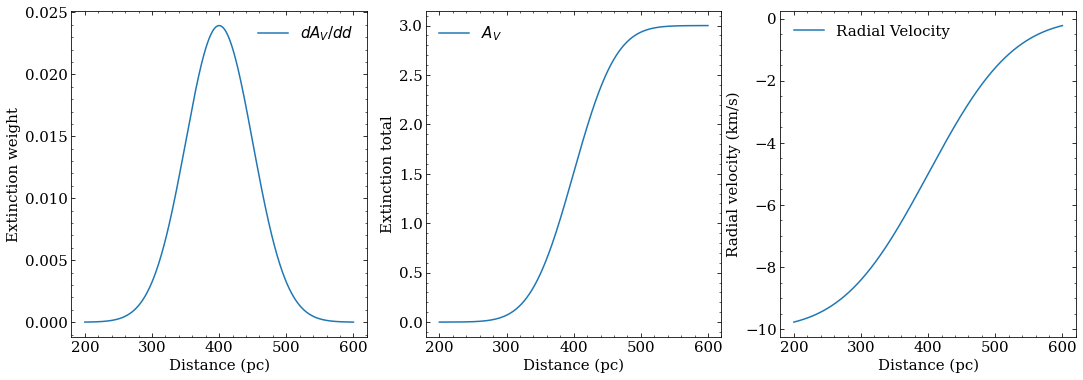

In [127]:
def density(distance, d0 = 400, width = 50, A = 3):
    # return A * np.exp(-(distance - d0)**2 / (2 * width**2))
    return A * norm.pdf(distance, d0, width)
def extinction(distance, d0 = 400, width = 50, A = 3):
    return A * norm.pdf(distance, d0, width)
def rvelo(distance, d0 = 400, v0 = -10 , vdisp = 100):
    return  v0 * (1-  norm.cdf(distance, d0,  vdisp))



distance = np.linspace(200, 600, 500)
dd_ = distance[1] - distance[0]

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 6))
axs[0].plot(distance, extinction(distance), label = '$dA_V / dd$')
axs[0].set_xlabel('Distance (pc)')
axs[0].set_ylabel('Extinction weight')
axs[0].legend()

axs[1].plot(distance, np.cumsum(extinction(distance) * dd_), label = '$A_V$')
axs[1].set_xlabel('Distance (pc)')
axs[1].set_ylabel('Extinction total')
axs[1].legend()



axs[2].plot(distance, rvelo(distance), label = 'Radial Velocity')
axs[2].set_xlabel('Distance (pc)')
axs[2].set_ylabel('Radial velocity (km/s)')
axs[2].legend()
plt.show()


In [128]:
lambda0 = 15272.42 # from Zasowski2015
dib_fwhm = 2.2 # angstroms, from https://www.aanda.org/articles/aa/pdf/2014/09/aa23061-13.pdf Cox2014 # from 2.2 to 4.4
# sigma0 = dib_fwhm / (2 * np.sqrt(2 * np.log(2)))
# print(sigma0)
sigma0 = 1
wavs = np.linspace(lambda0-10, lambda0+10, 200)

dd = 25
# def amplitude(extinction, sigma = sigma0): # from Zasowski2015
#     return 1/(np.sqrt(2 * np.pi) * sigma) * 1.02e-3 * np.cumsum(extinction) # Note that "extinction" in its current form is dAv/dd

def amplitude(dAv_dd, dd = 25,  sigma = 2): # from Zasowski2015
    return 1/(np.sqrt(2 * np.pi) * sigma) * 102e-3 * np.cumsum(dAv_dd) * dd

def dopplershift(v, lambda0 = lambda0):
     return (lambda0 * u.Angstrom * (c.c + v * u.km / u.s) / c.c).to(u.Angstrom).value

lambda0_d = dopplershift(rvelo(distance))
density_d = density(distance)



fn = lambda L0, A0: -0.1 * A0 *  np.exp(-(wavs - L0)**2 / (2 * sigma0**2))

# thing = np.zeros((len(distance), wavs))
thing = np.zeros((len(distance), len(wavs)))
for i in range(len(thing)):
     thing[i, :] = fn(lambda0_d[i], density_d[i])

# signal = 1 - np.sum(thing, axis = 1)

DIB =  np.sum(thing, axis = 0)


In [129]:
# signal_resolution = int((600 - 200) / 50) 
# kt_resolution = int((600 - 200) / 50) 

kt_dist = np.arange(200, 601, 25)
kt_extinction = extinction(kt_dist)
kt_resolution = len(kt_dist)

signal_dist = np.arange(200, 601, 25)
signal_dist = kt_dist
signal_extinction = extinction(signal_dist)
signal_rvelo = rvelo(signal_dist)
signal_doppler = dopplershift(signal_rvelo)
signal_resolution = len(signal_dist)

# fig, ax = plt.subplots()

# voxel_DIB = np.zeros((signal_resolution, len(wavs)))
# for i in range(signal_resolution):
#     voxel_DIB[i, :] = - 0.025 * signal_extinction[i] * np.exp(-(wavs - signal_doppler[i])**2 / (2 * sigma0**2))
    # voxel_DIB[i, :] =   fn(signal_rvelo[i], density_d[i])
#     ax.plot(wavs, voxel_DIB[i, :], linestyle = 'dashed')
# DIB_signal = np.sum(voxel_DIB, axis = 0)
# ax.plot(wavs, DIB_signal)
# plt.show()

In [130]:
print(kt_dist[1]-kt_dist[0])

25


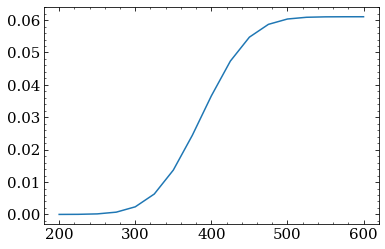

In [131]:
plt.plot(kt_dist,  amplitude(kt_extinction))

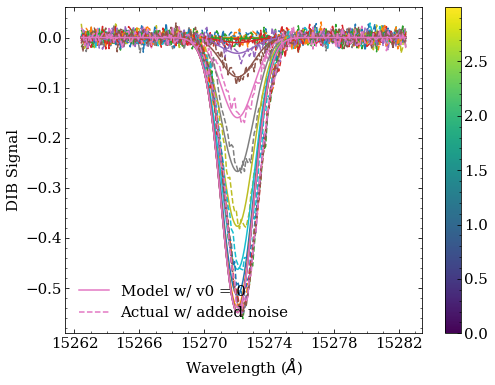

In [140]:
def get_signal(distance, v, a = np.copy(kt_extinction)):
    a[kt_dist > distance] = 0
    amp = -amplitude(a, dd = 25) 
    x = np.tile(wavs, (len(v), 1))
    vshift = dopplershift(v)
    voxel_signal = np.exp(-(x - vshift[:, np.newaxis])**2 / (2 * sigma0**2))
    # voxel_signal =  voxel_signal * -a[:, np.newaxis] * 2.5
    voxel_signal = voxel_signal * amp[:, np.newaxis]
    return np.sum(voxel_signal, axis = 0)
    # return voxel_signal

v0 = -7.5 *  np.ones(len(kt_dist))
# v0 = signal_rvelo

# plt.plot(wavs, get_signal(400, v0,np.copy(kt_extinction) ))
# plt.plot(wavs, get_signal(600, v0, np.copy(kt_extinction)))

def SIGNALS(d, v):
    signals = np.zeros((len(d), len(wavs)))
    # print(signals.shape)
    for i in range(len(d)):
        signals[i, :] = get_signal(d[i], v, np.copy(kt_extinction))
    return signals

true_sig = SIGNALS(kt_dist, signal_rvelo) 
true_sig = true_sig + np.random.normal(0, 0.01, true_sig.shape)
sig = SIGNALS(kt_dist, v0)

norm = colors.Normalize(0, np.max(np.cumsum(kt_extinction * dd)))
item = matplotlib.cm.ScalarMappable(norm = norm)
fig, ax = plt.subplots(figsize = (8,6))
for i in range(len(sig)):
    mod, = ax.plot(wavs, sig[i, :] )
    ax.plot(wavs, true_sig[i, :], linestyle = 'dashed', color = mod.get_color())

ax.legend(ax.get_lines()[-2:], ['Model w/ v0 = 0', 'Actual w/ added noise'], loc = 'lower left')
ax.set_xlabel('Wavelength ($\AA$)')
ax.set_ylabel('DIB Signal')
ax.set_xticks(np.arange(15262, 15285, 4))
fig.colorbar()
plt.show()

In [133]:
def minimize_this(v):
    sig = SIGNALS(kt_dist, v)
    return np.sum(np.power(sig - true_sig, 2))
from scipy.optimize import minimize
minimized = minimize(minimize_this, v0)

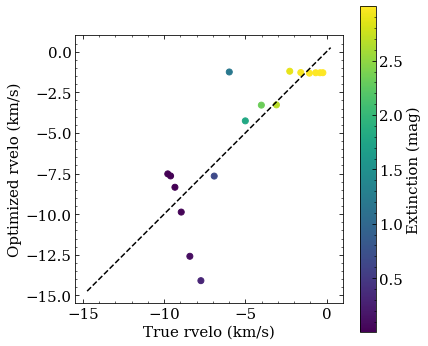

In [134]:
fig, ax = plt.subplots(figsize = (6,6))
points = ax.scatter(signal_rvelo, minimized.x, c = np.cumsum(kt_extinction) * dd )

axlims = np.ravel([ax.get_xlim(), ax.get_ylim()])
min = np.min(axlims)
max = np.max(axlims)
ax.plot((min, max), (min, max), linestyle = 'dashed', color = 'k')
ax.set_aspect('equal')
ax.set_xlabel('True rvelo (km/s)')
ax.set_ylabel('Optimized rvelo (km/s)')
fig.colorbar(points , label = 'Extinction (mag)')
plt.show()